<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0515.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mxnet_cu100 d2lzh

In [0]:
!mkdir -p ../data/pikachu

## 9.6 目标检测数据集 ( 皮卡丘 )

In [0]:
%matplotlib inline  
import d2lzh as d2l 
from mxnet import gluon, image 
from mxnet.gluon import utils as gutils 
import os 

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'} 
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)

In [0]:
def load_data_pikachu(batch_size, edge_size=256):
    data_dir = '../data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'), 
        path_imgidx=os.path.join(data_dir, 'train.idx'), 
        batch_size=batch_size, 
        data_shape=(3, edge_size, edge_size), 
        shuffle=True, 
        rand_crop=1, 
        min_object_covered=0.95, max_attempts=200
    )
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size, 
        data_shape=(3, edge_size, edge_size), shuffle=False
    )
    return train_iter, val_iter

In [5]:
batch_size, edge_size = 32, 256 
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

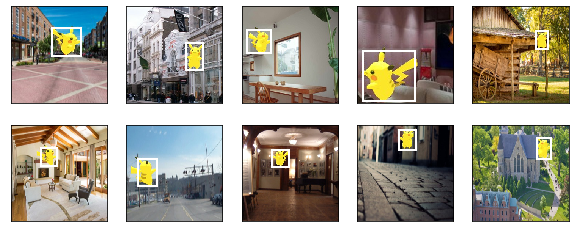

In [6]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255 
axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 9.7 单发多框检测 ( SSD )

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import autograd, contrib, gluon, image, init, nd 
from mxnet.gluon import loss as gloss, nn 
import time 

def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding=1)

In [0]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

In [9]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [0]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

In [11]:
concat_preds([Y1, Y2]).shape 

(2, 25300)

In [0]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1), 
            nn.BatchNorm(in_channels=num_channels), 
            nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk 

In [13]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape 

(2, 10, 10, 10)

In [14]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk 

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape 

(2, 64, 32, 32)

In [0]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk 

In [0]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [0]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5 
num_anchors = len(sizes[0]) + len(ratios[0]) - 1 

In [0]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes 
        for i in range(5):
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors, num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5 
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, 'blk_%d' % i), sizes[i], ratios[i], 
                getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))

        return (nd.concat(*anchors, dim=1), 
            concat_preds(cls_preds).reshape((0, -1, self.num_classes + 1)), 
            concat_preds(bbox_preds))
            

In [19]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


In [0]:
batch_size = 32 
train_iter, _ = d2l.load_data_pikachu(batch_size)

In [0]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.2, 'wd': 5e-4})

In [0]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox 

In [0]:
def cls_eval(cls_preds, cls_labels):
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

In [25]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, cls_preds, bbox_preds = net(X)
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size 
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size 

    if (epoch + 1) % 1 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start
        ))
            

epoch  1, class err 3.22e-03, bbox mae 3.55e-03, time 11.3 sec
epoch  2, class err 3.08e-03, bbox mae 3.30e-03, time 11.2 sec
epoch  3, class err 3.12e-03, bbox mae 3.24e-03, time 11.2 sec
epoch  4, class err 3.06e-03, bbox mae 3.17e-03, time 11.1 sec
epoch  5, class err 2.98e-03, bbox mae 3.00e-03, time 11.3 sec
epoch  6, class err 2.87e-03, bbox mae 3.01e-03, time 11.2 sec
epoch  7, class err 2.94e-03, bbox mae 3.03e-03, time 11.2 sec
epoch  8, class err 2.68e-03, bbox mae 2.90e-03, time 11.3 sec
epoch  9, class err 2.68e-03, bbox mae 2.79e-03, time 11.2 sec
epoch 10, class err 2.72e-03, bbox mae 2.88e-03, time 11.2 sec
epoch 11, class err 2.61e-03, bbox mae 2.78e-03, time 11.3 sec
epoch 12, class err 2.78e-03, bbox mae 2.82e-03, time 11.2 sec
epoch 13, class err 2.74e-03, bbox mae 2.83e-03, time 11.2 sec
epoch 14, class err 2.67e-03, bbox mae 2.77e-03, time 11.2 sec
epoch 15, class err 2.57e-03, bbox mae 2.69e-03, time 11.2 sec
epoch 16, class err 2.61e-03, bbox mae 2.72e-03, time 1

In [28]:
!git clone https://github.com/d2l-ai/d2l-zh.git

Cloning into 'd2l-zh'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15702 (delta 9), reused 8 (delta 4), pack-reused 15685
Receiving objects: 100% (15702/15702), 159.56 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (11132/11132), done.


In [0]:
!mkdir ../img

In [0]:
!cp ./d2l-zh/img/pikachu.jpg ../img/

In [0]:
img = image.imread('../img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)

In [0]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

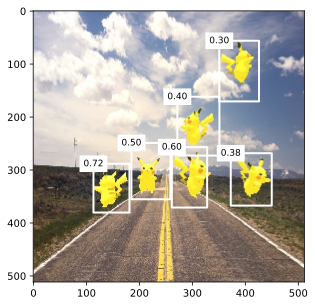

In [37]:
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue 
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)

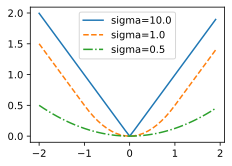

In [38]:
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = nd.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = nd.smooth_l1(x, scalar=s)
    d2l.plt.plot(x.asnumpy(), y.asnumpy(), l, label='sigma=%.1f' % s)
d2l.plt.legend();

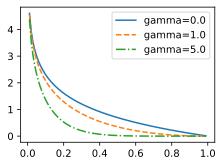

In [40]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * x.log()

x = nd.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x.asnumpy(), focal_loss(gamma, x).asnumpy(), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();

## 9.8 区域卷积神经网络 ( R-CNN ) 系列

In [41]:
from mxnet import nd 

X = nd.arange(16).reshape((1, 1, 4, 4))
X


[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]]]
<NDArray 1x1x4x4 @cpu(0)>

In [0]:
rois = nd.array([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

In [43]:
nd.ROIPooling(X, rois, pooled_size=(2, 2), spatial_scale=0.1)


[[[[ 5.  6.]
   [ 9. 10.]]]


 [[[ 9. 11.]
   [13. 15.]]]]
<NDArray 2x1x2x2 @cpu(0)>

## 9.9 语义分割和数据集

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import gluon, image, nd 
from mxnet.gluon import data as gdata, utils as gutils 
import os 
import sys 
import tarfile 

In [48]:
def download_voc_pascal(data_dir='../data'):
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
    fname = gutils.download(url, data_dir, sha1_hash=sha1)
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_dir)
    return voc_dir

voc_dir = download_voc_pascal()

In [0]:
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images()

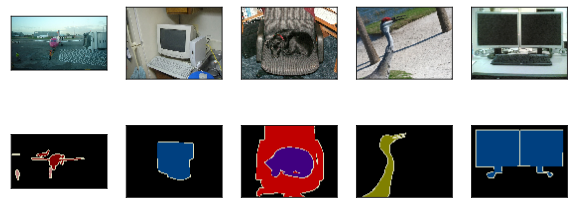

In [52]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

In [0]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [0]:
colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i 

def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [56]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>, 'aeroplane')

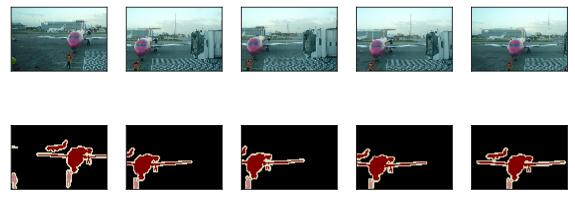

In [58]:
def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [0]:
class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size 
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)        
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label 
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std 

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1]
        )]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx], *self.crop_size)
        return (feature.transpose((2, 0, 1)), 
            voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [60]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 1114 examples
read 1078 examples


In [0]:
batch_size = 64 
num_workers = 4 
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard', num_workers=num_workers)

In [62]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


## 9.10 全卷积网络 ( FCN ) 

In [0]:
%matplotlib inline 
import d2lzh as d2l 
from mxnet import gluon, image, init, nd 
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn 
import numpy as np 
import sys 

In [6]:
X = nd.arange(1, 17).reshape((1, 1, 4, 4))
K = nd.arange(1, 10).reshape((1, 1, 3, 3))
conv = nn.Conv2D(channels=1, kernel_size=3)
conv.initialize(init.Constant(K))
conv(X), K

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[[[1. 2. 3.]
    [4. 5. 6.]
    [7. 8. 9.]]]]
 <NDArray 1x1x3x3 @cpu(0)>)

In [7]:
W, k = nd.zeros((4, 16)), nd.zeros(11)
k[:3], k[4:7], k[8:] = K[0, 0, 0, :], K[0, 0, 1, :], K[0, 0, 2, :]
W[0, 0:11], W[1, 1:12], W[2, 4:15], W[3, 5:16] = k, k, k, k 
nd.dot(W, X.reshape(16)).reshape((1, 1, 2, 2)), W 

(
 [[[[348. 393.]
    [528. 573.]]]]
 <NDArray 1x1x2x2 @cpu(0)>, 
 [[1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9. 0.]
  [0. 0. 0. 0. 0. 1. 2. 3. 0. 4. 5. 6. 0. 7. 8. 9.]]
 <NDArray 4x16 @cpu(0)>)

In [8]:
conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv.initialize()

X = nd.random.uniform(shape=(1, 3, 64, 64))
Y = conv(X)
Y.shape

(1, 10, 32, 32)

In [9]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize()
conv_trans(Y).shape 

(1, 3, 64, 64)

In [10]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ), Dense(512 -> 1000, linear))

In [0]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

In [12]:
X = nd.random.uniform(shape=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

In [0]:
num_classes = 21 
net.add(nn.Conv2D(num_classes, kernel_size=1), 
    nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16, strides=32))

In [0]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2 
    if kernel_size % 2 == 1:
        center = factor - 1 
    else:
        center = factor - 0.5 
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor) 
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt 
    return nd.array(weight)

In [0]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

In [0]:
!cp ./d2l-zh/img/catdog.jpg ../img/

In [0]:
img = image.imread('../img/catdog.jpg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255 
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

input image shape: (561, 728, 3)
output image shape: (1122, 1456, 3)


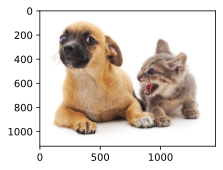

In [18]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy()); 
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy());

In [0]:
net[-1].initialize(init.Constant(bilinear_kernel(num_classes, num_classes, 64)))
net[-2].initialize(init=init.Xavier())

In [20]:
crop_size, batch_size, colormap2label = (320, 480), 32, nd.zeros(256**3)
for i, cm in enumerate(d2l.VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i 
voc_dir = d2l.download_voc_pascal(data_dir='../data')

num_workers = 4 
train_iter = gdata.DataLoader(
    d2l.VOCSegDataset(True, crop_size, voc_dir, colormap2label), batch_size, 
    shuffle=True, last_batch='discard', num_workers=num_workers
)
test_iter = gdata.DataLoader(
    d2l.VOCSegDataset(False, crop_size, voc_dir, colormap2label), batch_size, 
    last_batch='discard', num_workers=num_workers
)

read 1114 examples
read 1078 examples


In [21]:
ctx = d2l.try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 1e-3})
d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

training on [gpu(0)]
epoch 1, loss 1.2286, train acc 0.742, test acc 0.813, time 35.4 sec
epoch 2, loss 0.4995, train acc 0.847, test acc 0.829, time 34.4 sec
epoch 3, loss 0.4193, train acc 0.865, test acc 0.841, time 33.8 sec
epoch 4, loss 0.3459, train acc 0.885, test acc 0.849, time 33.6 sec
epoch 5, loss 0.2979, train acc 0.899, test acc 0.839, time 33.6 sec


In [0]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = X.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

In [0]:
def label2image(pred):
    colormap = nd.array(d2l.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

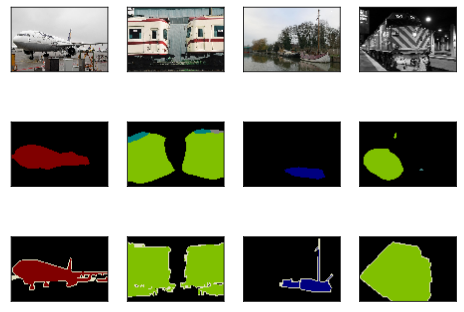

In [33]:
test_images, test_labels = d2l.read_voc_images(is_train=False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);